# Setup

In [300]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Notebook settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import pandas as pd
import numpy as np
import os

np.random.seed(47)

<br/><br/>

# Introduction 

#### Background

Our client is a provider of textbooks and other learning materials for educational institutions throughout Spain and many Latin American countries. Recently, they've witnessed a trend of customers in the Spanish market switching away from traditional resources, such as those sold by our client, to alternative resources.

#### Task

Our client would like to use course-level information from 2019 and three previous years to predict the behaviour of customers in 2019.

Specifically, we must establish an alorithm that achieves the following:

- Predicts whether a pre-existing course will switch from being a user to a non-user.
- Predict wheter newly created courses will be non-users.

This is a supervised binary classification task, with the target variable being encoded in the following manner:

- **1** – a pre-existing course will switch from being a traditional user to a non-user **or** a newly created course will be a non-user.
- **0** – a pre-existing course will remain a user or non-user, **or** a newly created course will be a user.

Our task is to establish an alorithm that maximizes F1-Score when making predictions for 2019. F1-Score is a harmonic mean between Precision and Recall. More can be read about this metric [here](https://en.wikipedia.org/wiki/F1_score).

#### Data

The data used for this task are:

**Customer Information Datasets**, of which there are four, one for each year from 2016 to 2019. They each contain approximately 600,000 records and include the following features:

- **Client ID** - the school code
- **Year**
- **Course** – education level
- **Subject**
- **Type of Material**
- **Language**
- **Type of Support** – current medium of learning resources (print, digital, hybrid, etc.)
- **Class Size**
- **Value** – the value of the course, were it to be a customer
- **Editorial Group*** – the current supplier of matieral (1 = client, 90 = non-use, other = competitors)

*not included for 2019

<br/><br/>

<br/><br/>

# 1. EDA & Cleaning

## 1.1 – Load Data

In [301]:
df16 = pd.read_csv("Data/CDS_2016_va", encoding='cp1252')
df17 = pd.read_csv("Data/CDS_2017_va", encoding='cp1252')
df18 = pd.read_csv("Data/CDS_2018_va", encoding='cp1252')
df19 = pd.read_csv("Data/CDS_2019_NO_LABEL", encoding='cp1252')

dfs = [df16, df17, df18, df19]

<br/><br/>

## 1.2 – Overview of Data

In [302]:
display(df16.head(), df17.head(), df18.head(), df19.head())

,Id_Cliente,Año Natural,Curso,Asignatura,Tipo Material Educativo,Grupo Editorial,Lengua,Tipo Soporte Actual,Variable 1,Variable 2
0,113958,2016,27,65,3,31,26,1,16.0,70.72
1,113958,2016,27,53,2,31,26,1,16.0,288.48
2,113958,2016,24,79,1,90,26,1,8.0,101.52
3,113958,2016,26,53,3,31,26,1,36.0,199.08
4,113958,2016,28,48,1,90,13,1,22.0,401.06


,Id_Cliente,Año natural,Curso,Asignatura,Tipo Material Educativo,Grupo Editorial,Lengua,Tipo Soporte Actual,Variable1,Variable2
0,113956,2017,35,8,1,3,26,1,32.0,881.28
1,113956,2017,33,40,1,3,26,1,81.0,2353.05
2,113956,2017,32,73,1,90,26,1,78.0,1998.36
3,113956,2017,32,65,3,13,26,1,78.0,852.54
4,113956,2017,32,65,3,13,13,1,60.0,655.80


,Id_Cliente,Año natural,Curso,Asignatura,Tipo Material Educativo,Grupo Editorial,Lengua,Tipo Soporte Actual,Variable1,Variable2
0,113956,18,c35,37,1,3,13,1,38.0,1046.90
1,113956,18,c33,37,1,5,13,1,60.0,1653.60
2,113956,18,c34,48,3,10,13,1,143.0,1364.22
3,113956,18,c35,47,1,90,26,1,11.0,262.46
4,113956,18,c35,82,1,90,26,1,11.0,311.08


,Id_Cliente,Año natural,Curso,Asignatura,Tipo Material Educativo,Lengua,Tipo Soporte Actual,Variable1,Variable2
0,113956,2019,33,48,3,13,1,150.0,22.5150
1,113956,2019,33,65,1,26,1,90.0,22.1760
2,113956,2019,32,8,1,26,2,96.0,12.8640
3,113956,2019,32,60,1,26,2,68.0,9.1188
4,113956,2019,32,73,1,13,2,53.0,7.1020


In [303]:
for df in dfs:
    print(df.info(), '\n'*2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612727 entries, 0 to 612726
Data columns (total 10 columns):
Id_Cliente                 612727 non-null int64
Año Natural                612727 non-null int64
Curso                      612727 non-null int64
Asignatura                 612727 non-null int64
Tipo Material Educativo    612727 non-null int64
Grupo Editorial            612727 non-null int64
Lengua                     612727 non-null int64
Tipo Soporte Actual        612727 non-null int64
Variable 1                 612727 non-null float64
Variable 2                 612727 non-null float64
dtypes: float64(2), int64(8)
memory usage: 46.7 MB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646342 entries, 0 to 646341
Data columns (total 10 columns):
Id_Cliente                 646342 non-null int64
Año natural                646342 non-null int64
Curso                      646342 non-null int64
Asignatura                 646342 non-null int64
Tipo Material Educativo    64

In [314]:
display(df16.describe(), df17.describe(), df18.describe(), df19.describe())

,class_size,value
count,612727.000000,612727.000000
mean,45.069315,934.915779
std,37.007351,859.368609
min,0.000000,0.000000
25%,21.000000,378.300000
50%,37.000000,704.100000
75%,57.000000,1249.600000
max,1540.000000,33514.140000


,class_size,value
count,584918.00000,584918.000000
mean,44.98450,966.630357
std,37.10939,904.725733
min,0.00000,0.000000
25%,21.00000,389.180000
50%,36.00000,724.090000
75%,57.00000,1292.037500
max,1540.00000,32478.160000


,class_size,value
count,619854.000000,619854.000000
mean,44.777751,958.139089
std,36.517757,916.106668
min,0.000000,0.000000
25%,21.000000,366.240000
50%,36.000000,706.590000
75%,57.000000,1291.320000
max,1506.000000,34617.440000


,class_size,value
count,617860.000000,617860.000000
mean,44.693696,963.086268
std,36.823918,932.166154
min,0.000000,0.000000
25%,20.000000,363.090000
50%,36.000000,708.210000
75%,56.000000,1294.580000
max,1506.000000,34617.440000


<br/><br/>

## 1.3 – Column Consistency

Here, we ensure consistency among the columns by:

1. Adding the "Grupo Editorial" column to the 2019 dataset and filling it with NAs
2. Rename columns with English names and reorder them for consistency
3. Convert datatypes

### 1.3.1 – Add "Grupo Editorial" to 2019

In [304]:
df19['Grupo Editorial'] = np.NaN

### 1.3.2 – Clean and Rearrange Columns

In [305]:
for df in dfs[:-1]:
    df.columns = ['client_id', 'year', 'course', 'subject', 'material_type', 'editorial_group', 'language', 'support_type', 'class_size', 'value']

df19.columns = ['client_id', 'year', 'course', 'subject', 'material_type', 'language', 'support_type', 'class_size', 'value', 'editorial_group']

In [306]:
df18['year'] = '2018'
df18['course'] = df18['course'].str.replace('c', '', regex = True).astype(int)
df19['value'] = df19['value']*100

In [307]:
df16['_id'] = df16['client_id'].astype(str) + df16['course'].astype(str) + df16['subject'].astype(str) + df16['language'].astype(str) + df16['material_type'].astype(str) + df16['support_type'].astype(str)
df17['_id'] = df17['client_id'].astype(str) + df17['course'].astype(str) + df17['subject'].astype(str) + df17['language'].astype(str) + df17['material_type'].astype(str) + df17['support_type'].astype(str)
df18['_id'] = df18['client_id'].astype(str) + df18['course'].astype(str) + df18['subject'].astype(str) + df18['language'].astype(str) + df18['material_type'].astype(str) + df18['support_type'].astype(str)
df19['_id'] = df19['client_id'].astype(str) + df19['course'].astype(str) + df19['subject'].astype(str) + df19['language'].astype(str) + df19['material_type'].astype(str) + df19['support_type'].astype(str)


df16 = df16[['_id', 'client_id', 'year', 'course', 'subject', 'material_type', 'language', 'support_type', 'class_size', 'value', 'editorial_group']]
df17 = df17[['_id', 'client_id', 'year', 'course', 'subject', 'material_type', 'language', 'support_type', 'class_size', 'value', 'editorial_group']]
df18 = df18[['_id', 'client_id', 'year', 'course', 'subject', 'material_type', 'language', 'support_type', 'class_size', 'value', 'editorial_group']]
df19 = df19[['_id', 'client_id', 'year', 'course', 'subject', 'material_type', 'language', 'support_type', 'class_size', 'value', 'editorial_group']]

dfs = [df16, df17, df18, df19]

### 1.3.3 – Change Datatypes

In [308]:
for df in dfs:
    df[list(df.columns.difference(['class_size', 'value']))] = df[list(df.columns.difference(['class_size', 'value']))].astype('category')

In [309]:
for df in dfs:
    print(df.dtypes, '\n')

_id                category
client_id          category
year               category
course             category
subject            category
material_type      category
language           category
support_type       category
class_size          float64
value               float64
editorial_group    category
dtype: object 

_id                category
client_id          category
year               category
course             category
subject            category
material_type      category
language           category
support_type       category
class_size          float64
value               float64
editorial_group    category
dtype: object 

_id                category
client_id          category
year               category
course             category
subject            category
material_type      category
language           category
support_type       category
class_size          float64
value               float64
editorial_group    category
dtype: object 

_id                category


<br/><br/>

## 1.4 – Handle NAs and Duplicates

### 1.4.1 – Search for NAs

In [310]:
i = 2016
for df in dfs:
    print('\033[1m', i, '\033[0m')
    print(sum(df.isna().sum()), '\n'*2)
    i += 1

 2016 
0 


 2017 
0 


 2018 
0 


 2019 
617860 




The only NAs are those we created for the "editorial_group" column in the 2019 dataset.

### 1.4.2 – Identify Duplicates

In [311]:
i = 2016
for df in dfs:
    print('\033[1m', i, '\033[0m')
    print(sum(df.duplicated()), '\n')
    i += 1

 2016 
0 

 2017 
30712 

 2018 
0 

 2019 
0 



### 1.4.3 – Remove Duplicates

In [312]:
for df in dfs:
    df.drop_duplicates(keep = False, inplace = True)

In [313]:
display(df16, df17, df18, df19)

,_id,client_id,year,course,subject,material_type,language,support_type,class_size,value,editorial_group
0,11395827652631,113958,2016,27,65,3,26,1,16.0,70.72,31
1,11395827532621,113958,2016,27,53,2,26,1,16.0,288.48,31
2,11395824792611,113958,2016,24,79,1,26,1,8.0,101.52,90
3,11395826532631,113958,2016,26,53,3,26,1,36.0,199.08,31
4,11395828481311,113958,2016,28,48,1,13,1,22.0,401.06,90
...,...,...,...,...,...,...,...,...,...,...,...
612722,21077837611311,210778,2016,37,61,1,13,1,51.0,1873.74,90
612723,21077837501311,210778,2016,37,50,1,13,1,5.0,183.70,90
612724,2107783771311,210778,2016,37,7,1,13,1,0.0,0.00,1
612725,21077836421311,210778,2016,36,42,1,13,1,3.0,103.50,90


,_id,client_id,year,course,subject,material_type,language,support_type,class_size,value,editorial_group
0,1139563582611,113956,2017,35,8,1,26,1,32.0,881.28,3
1,11395633402611,113956,2017,33,40,1,26,1,81.0,2353.05,3
2,11395632732611,113956,2017,32,73,1,26,1,78.0,1998.36,90
3,11395632652631,113956,2017,32,65,3,26,1,78.0,852.54,13
4,11395632651331,113956,2017,32,65,3,13,1,60.0,655.80,13
...,...,...,...,...,...,...,...,...,...,...,...
615624,21181723631311,211817,2017,23,63,1,13,1,63.0,2046.87,5
615625,21181723481311,211817,2017,23,48,1,13,1,21.0,295.47,34
615626,21181723511321,211817,2017,23,51,2,13,1,21.0,261.45,6
615628,21181724511321,211817,2017,24,51,2,13,1,20.0,265.60,6


,_id,client_id,year,course,subject,material_type,language,support_type,class_size,value,editorial_group
0,11395635371311,113956,2018,35,37,1,13,1,38.0,1046.90,3
1,11395633371311,113956,2018,33,37,1,13,1,60.0,1653.60,5
2,11395634481331,113956,2018,34,48,3,13,1,143.0,1364.22,10
3,11395635472611,113956,2018,35,47,1,26,1,11.0,262.46,90
4,11395635822611,113956,2018,35,82,1,26,1,11.0,311.08,90
...,...,...,...,...,...,...,...,...,...,...,...
619849,2125363771011,212536,2018,37,7,1,10,1,40.0,1469.60,16
619850,212536362411011,212536,2018,36,241,1,10,1,15.0,493.05,5
619851,21253637481321,212536,2018,37,48,2,13,1,80.0,827.20,4
619852,21253637391011,212536,2018,37,39,1,10,1,33.0,1483.02,2


,_id,client_id,year,course,subject,material_type,language,support_type,class_size,value,editorial_group
0,11395633481331,113956,2019,33,48,3,13,1,150.0,2251.50,NaN
1,11395633652611,113956,2019,33,65,1,26,1,90.0,2217.60,NaN
2,1139563282612,113956,2019,32,8,1,26,2,96.0,1286.40,NaN
3,11395632602612,113956,2019,32,60,1,26,2,68.0,911.88,NaN
4,11395632731312,113956,2019,32,73,1,13,2,53.0,710.20,NaN
...,...,...,...,...,...,...,...,...,...,...,...
617855,21253636481311,212536,2019,36,48,1,13,1,99.0,4671.81,NaN
617856,21253636421311,212536,2019,36,42,1,13,1,10.0,354.20,NaN
617857,2125363681011,212536,2019,36,8,1,10,1,40.0,1413.60,NaN
617858,21253637481321,212536,2019,37,48,2,13,1,80.0,827.20,NaN


<br/><br/>

## 1.5 – Handle Numeric Data

### 1.5.1 – Visualize Numeric Variables

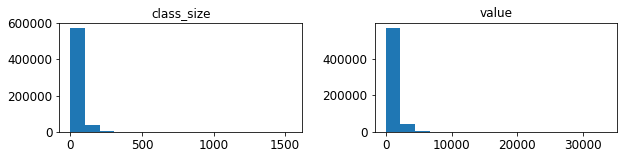

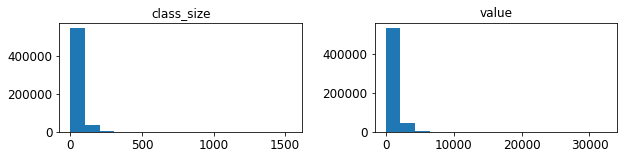

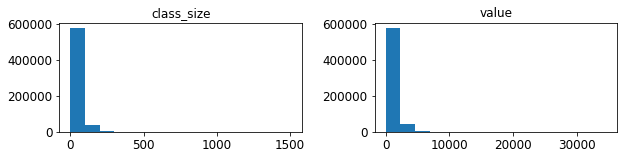

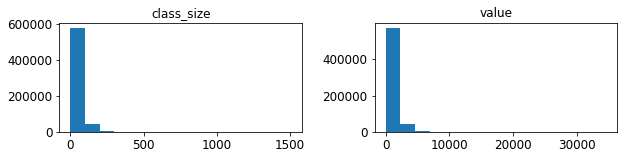

In [315]:
for df in dfs:
    df.hist(bins = 15, figsize = (10, 2), grid = False)

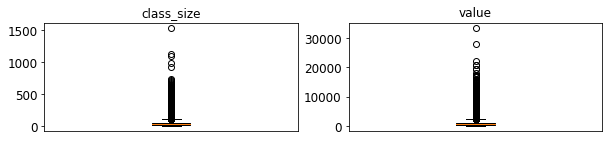

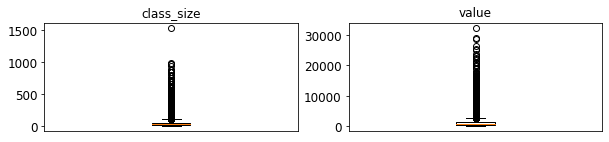

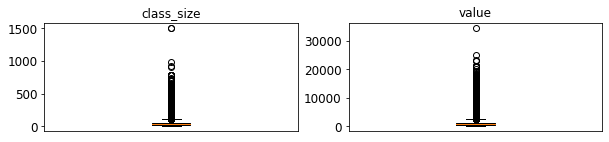

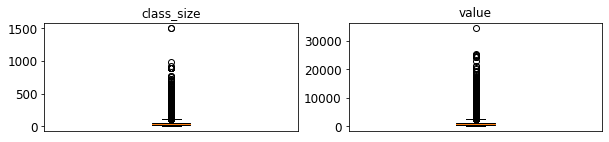

In [316]:
for df in dfs:
    fig, axs = plt.subplots(1,2, figsize = (10, 2))
    
    axs[0].boxplot(df['class_size'])
    axs[0].set_title('class_size')
    axs[0].set_xticks([])

    axs[1].boxplot(df['value'])
    axs[1].set_title('value')
    axs[1].set_xticks([])

### 1.5.2 – Convert to Normal Distribution

In [317]:
from scipy.stats import boxcox

for df in dfs:
    df['class_size'] = boxcox((df['class_size'] + 1), 0)
    df['value'] = boxcox((df['value'] + 1), 0)

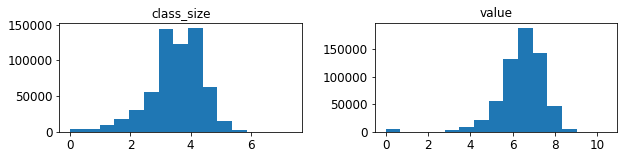

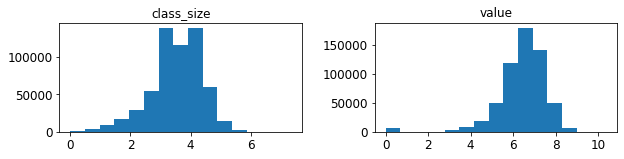

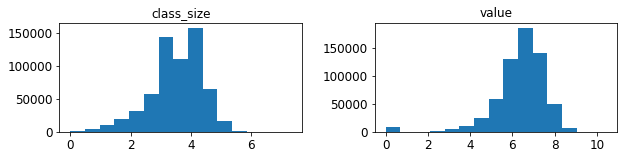

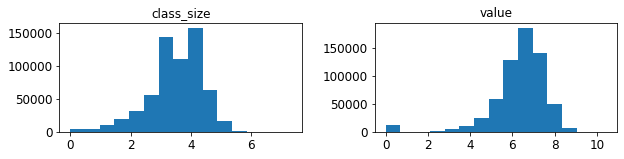

In [318]:
for df in dfs:
    df.hist(bins = 15, figsize = (10, 2), grid = False)

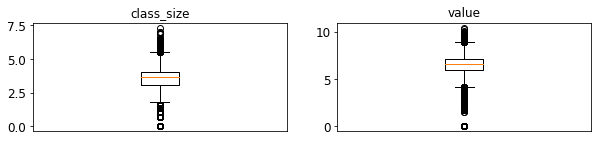

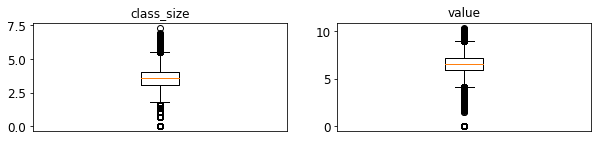

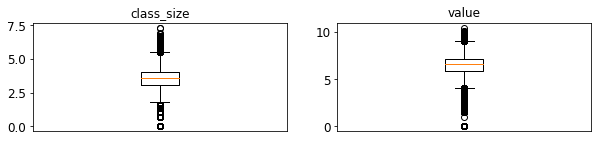

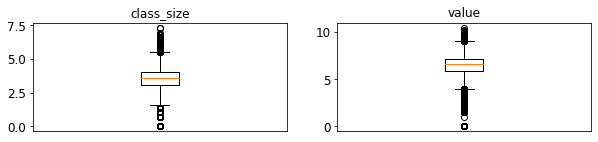

In [319]:
for df in dfs:
    fig, axs = plt.subplots(1,2, figsize = (10, 2))
    
    axs[0].boxplot(df['class_size'])
    axs[0].set_title('class_size')
    axs[0].set_xticks([])

    axs[1].boxplot(df['value'])
    axs[1].set_title('value')
    axs[1].set_xticks([])

There remain outliers. We will deal with these during our modeling phase.

## 1.6 – Explore Categorical Data

In [320]:
for col in df16.columns.difference(['_id', 'client_id', 'editorial_group']):
    if df16.dtypes[col].name == 'category':
        with pd.option_context('display.max_rows', None):
            print(df16[col].value_counts(), '\n')

28    57726
29    57060
30    56983
27    56041
31    55941
26    55803
35    44018
34    41236
32    35610
33    35073
37    33829
36    32172
25    17586
24    17186
23    15375
22      789
21      225
20       74
Name: course, dtype: int64 

13    397434
10    121336
18     56030
26     37927
Name: language, dtype: int64 

1    503592
3     64445
2     37340
4      7350
Name: material_type, dtype: int64 

48     91370
60     60977
54     59714
79     45231
65     43279
53     40730
73     30166
265    20681
38     19171
15     17422
63     16931
13     16722
40     12279
8      11701
18     11687
82     10150
37      9844
61      7981
62      6713
50      5224
26      5080
230     4363
51      4358
239     4103
43      4016
35      3954
274     3911
24      3498
238     2951
78      2606
36      2580
259     2353
47      2036
7       1992
42      1907
39      1892
22      1693
41      1690
241     1657
45      1651
72      1579
25      1419
89      1285
29      1098
236      976
243

In [321]:
for col in df17.columns.difference(['_id', 'client_id', 'editorial_group']):
    if df17.dtypes[col].name == 'category':
        with pd.option_context('display.max_rows', None):
            print(df17[col].value_counts(), '\n')

28    54772
29    54256
30    54030
31    53163
27    53128
26    52609
35    41781
34    39626
33    34370
32    34305
37    32880
36    31393
25    16697
24    16252
23    14634
22      741
21      220
20       61
Name: course, dtype: int64 

13    382878
10    113893
18     52374
26     35773
Name: language, dtype: int64 

1    485419
3     58424
2     34511
4      6564
Name: material_type, dtype: int64 

48     86955
60     57304
54     56457
79     43124
65     40803
53     38264
73     27577
265    20990
38     18888
15     17334
13     16496
63     14609
40     11769
8      10982
18     10270
82      9818
37      9744
61      7822
62      6445
26      5256
50      5065
230     4934
239     4509
51      3917
43      3879
35      3751
274     3555
24      3379
259     3152
238     2994
78      2505
36      2472
47      2012
7       1913
22      1871
42      1837
39      1835
241     1758
45      1635
41      1520
25      1415
89      1221
72      1212
90      1135
236     1121
262

In [322]:
for col in df18.columns.difference(['_id', 'client_id', 'editorial_group']):
    if df18.dtypes[col].name == 'category':
        with pd.option_context('display.max_rows', None):
            print(df18[col].value_counts(), '\n')

28    57859
29    57331
30    57216
31    56517
27    55654
26    55376
35    44831
34    42464
32    36505
33    36493
37    35098
36    33579
25    17341
24    16943
23    15514
22      828
21      239
20       66
Name: course, dtype: int64 

13    405601
10    121451
18     55484
26     37318
Name: language, dtype: int64 

1    519497
3     58551
2     34785
4      7021
Name: material_type, dtype: int64 

48     91765
60     59475
54     59439
79     46140
65     42872
53     40333
73     29138
265    23045
38     19857
15     18967
13     17698
63     14875
40     12433
8      11124
82     10558
37     10444
18     10333
61      8387
62      6892
26      5740
230     5659
50      5484
239     5421
43      4145
259     4110
274     4016
35      4012
51      3978
24      3593
238     3394
78      2691
36      2659
47      2116
22      2067
7       2037
39      1959
42      1921
241     1865
45      1711
41      1395
25      1365
236     1301
90      1272
89      1245
262     1052
72 

In [323]:
for col in df19.columns.difference(['_id', 'client_id', 'editorial_group']):
    if df19.dtypes[col].name == 'category':
        with pd.option_context('display.max_rows', None):
            print(df19[col].value_counts(), '\n')

28    56843
30    56575
29    56366
31    55919
27    55201
26    55005
35    45473
34    42799
33    36842
32    36647
37    35272
36    33746
25    17368
24    17044
23    15653
22      812
21      232
20       63
Name: course, dtype: int64 

13    402447
10    122200
18     55267
26     37945
0          1
Name: language, dtype: int64 

1    521649
3     57938
2     34379
4      3894
Name: material_type, dtype: int64 

48     91795
54     59340
60     58998
79     45973
65     42479
53     40503
73     28991
265    23138
38     20378
15     19027
13     17548
63     14519
40     12508
8      11212
82     10723
37     10556
18     10337
61      8409
62      6928
26      5820
230     5775
239     5689
50      5528
259     4595
43      4135
35      3998
51      3975
24      3603
238     3500
274     2784
78      2677
36      2645
47      2214
22      2135
7       2032
39      1966
241     1937
42      1930
45      1738
41      1410
236     1391
90      1298
89      1256
262     1083
279

We don't see any abnormal values. However, there are a lot of categories for the subject variable. We will have to revisit this when making the final dataset preparations for modeling.

<br/><br/>

## 1.7 – Overview and Insights I

### 1.7.1 – Structure of Data

In [324]:
display(df16, df17, df18, df19)

,_id,client_id,year,course,subject,material_type,language,support_type,class_size,value,editorial_group
0,11395827652631,113958,2016,27,65,3,26,1,2.833213,4.272770,31
1,11395827532621,113958,2016,27,53,2,26,1,2.833213,5.668086,31
2,11395824792611,113958,2016,24,79,1,26,1,2.197225,4.630058,90
3,11395826532631,113958,2016,26,53,3,26,1,3.610918,5.298717,31
4,11395828481311,113958,2016,28,48,1,13,1,3.135494,5.996601,90
...,...,...,...,...,...,...,...,...,...,...,...
612722,21077837611311,210778,2016,37,61,1,13,1,3.951244,7.536225,90
612723,21077837501311,210778,2016,37,50,1,13,1,1.791759,5.218733,90
612724,2107783771311,210778,2016,37,7,1,13,1,0.000000,0.000000,1
612725,21077836421311,210778,2016,36,42,1,13,1,1.386294,4.649187,90


,_id,client_id,year,course,subject,material_type,language,support_type,class_size,value,editorial_group
0,1139563582611,113956,2017,35,8,1,26,1,3.496508,6.782509,3
1,11395633402611,113956,2017,33,40,1,26,1,4.406719,7.763893,3
2,11395632732611,113956,2017,32,73,1,26,1,4.369448,7.600582,90
3,11395632652631,113956,2017,32,65,3,26,1,4.369448,6.749392,13
4,11395632651331,113956,2017,32,65,3,13,1,4.110874,6.487380,13
...,...,...,...,...,...,...,...,...,...,...,...
615624,21181723631311,211817,2017,23,63,1,13,1,4.158883,7.624556,5
615625,21181723481311,211817,2017,23,48,1,13,1,3.091042,5.691946,34
615626,21181723511321,211817,2017,23,51,2,13,1,3.091042,5.570061,6
615628,21181724511321,211817,2017,24,51,2,13,1,3.044522,5.585749,6


,_id,client_id,year,course,subject,material_type,language,support_type,class_size,value,editorial_group
0,11395635371311,113956,2018,35,37,1,13,1,3.663562,6.954543,3
1,11395633371311,113956,2018,33,37,1,13,1,4.110874,7.411315,5
2,11395634481331,113956,2018,34,48,3,13,1,4.969813,7.219071,10
3,11395635472611,113956,2018,35,47,1,26,1,2.484907,5.573902,90
4,11395635822611,113956,2018,35,82,1,26,1,2.484907,5.743260,90
...,...,...,...,...,...,...,...,...,...,...,...
619849,2125363771011,212536,2018,37,7,1,10,1,3.713572,7.293426,16
619850,212536362411011,212536,2018,36,241,1,10,1,2.772589,6.202637,5
619851,21253637481321,212536,2018,37,48,2,13,1,4.394449,6.719255,4
619852,21253637391011,212536,2018,37,39,1,10,1,3.526361,7.302510,2


,_id,client_id,year,course,subject,material_type,language,support_type,class_size,value,editorial_group
0,11395633481331,113956,2019,33,48,3,13,1,5.017280,7.719796,NaN
1,11395633652611,113956,2019,33,65,1,26,1,4.510860,7.704632,NaN
2,1139563282612,113956,2019,32,8,1,26,2,4.574711,7.160380,NaN
3,11395632602612,113956,2019,32,60,1,26,2,4.234107,6.816604,NaN
4,11395632731312,113956,2019,32,73,1,13,2,3.988984,6.566954,NaN
...,...,...,...,...,...,...,...,...,...,...,...
617855,21253636481311,212536,2019,36,48,1,13,1,4.605170,8.449516,NaN
617856,21253636421311,212536,2019,36,42,1,13,1,2.397895,5.872681,NaN
617857,2125363681011,212536,2019,36,8,1,10,1,3.713572,7.254602,NaN
617858,21253637481321,212536,2019,37,48,2,13,1,4.394449,6.719255,NaN


### 1.7.2 – Market Share

In [325]:
i = 2016

for df in dfs[:-1]:
    eg = pd.DataFrame(df["editorial_group"].value_counts())
    eg.columns = ['count']
    eg['%'] = round((df["editorial_group"].value_counts())/len(df)*100, 2)
    print('\033[1m', i, '\033[0m')
    print(eg.head())
    print('\n')
    i += 1

 2016 
     count      %
90  172621  28.17
3    89248  14.57
1    75780  12.37
2    52359   8.55
4    43808   7.15


 2017 
     count      %
90  176741  30.22
3    84166  14.39
1    68988  11.79
2    48079   8.22
4    40213   6.87


 2018 
     count      %
90  201414  32.49
3    86961  14.03
1    68467  11.05
2    49908   8.05
4    41277   6.66




Non-use (90) is clearly rising. It appears that our client's competitors' market share is decreasing as well. Thus, we can conclude that this trend is having an effect on the whole market, not just a few companies.

<br/><br/>

<br/><br/>

# 2. Prepare Data for Modeling

## 2.1 – Create Single Dataframe

### 2.1.1 – Create Dataframes for Base and Following Year Pairs

In [326]:
merge_cols = ['_id', 'client_id', 'course', 'subject', 'language', 'material_type', 'support_type']

df16_17 = pd.merge(df16, df17, how = 'right', 
                  left_on = merge_cols, right_on = merge_cols,
                  suffixes = ('_1', '_2'))

df17_18 = pd.merge(df17, df18, how = 'right', 
                  left_on = merge_cols, right_on = merge_cols,
                  suffixes = ('_1', '_2'))

df18_19 = pd.merge(df18, df19, how = 'right', 
                  left_on = merge_cols, right_on = merge_cols,
                  suffixes = ('_1', '_2'))

In [327]:
display(df16_17, df17_18, df18_19)

,_id,client_id,year_1,course,subject,material_type,language,support_type,class_size_1,value_1,editorial_group_1,year_2,class_size_2,value_2,editorial_group_2
0,11395827652631,113958,2016,27,65,3,26,1,2.833213,4.272770,31,2017,2.944439,4.393461,31
1,11395827532621,113958,2016,27,53,2,26,1,2.833213,5.668086,31,2017,2.944439,5.820795,31
2,11395824792611,113958,2016,24,79,1,26,1,2.197225,4.630058,90,2017,2.197225,4.645544,90
3,11395826532631,113958,2016,26,53,3,26,1,3.610918,5.298717,31,2017,4.007333,5.707907,31
4,11395828481311,113958,2016,28,48,1,13,1,3.135494,5.996601,90,2017,2.890372,5.762209,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584913,21181723631311,211817,NaN,23,63,1,13,1,NaN,NaN,NaN,2017,4.158883,7.624556,5
584914,21181723481311,211817,NaN,23,48,1,13,1,NaN,NaN,NaN,2017,3.091042,5.691946,34
584915,21181723511321,211817,NaN,23,51,2,13,1,NaN,NaN,NaN,2017,3.091042,5.570061,6
584916,21181724511321,211817,NaN,24,51,2,13,1,NaN,NaN,NaN,2017,3.044522,5.585749,6


,_id,client_id,year_1,course,subject,material_type,language,support_type,class_size_1,value_1,editorial_group_1,year_2,class_size_2,value_2,editorial_group_2
0,1139563582611,113956,2017,35,8,1,26,1,3.496508,6.782509,3,2018,3.663562,6.954543,3
1,11395633402611,113956,2017,33,40,1,26,1,4.406719,7.763893,3,2018,4.510860,7.851506,3
2,11395635541311,113956,2017,35,54,1,13,1,4.875197,8.182364,3,2018,4.934474,8.224099,3
3,11395635372611,113956,2017,35,37,1,26,1,3.761200,7.054536,3,2018,3.931826,7.228751,3
4,11395632532612,113956,2017,32,53,1,26,2,4.934474,7.497363,3,2018,4.574711,7.155896,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619849,2125363771011,212536,NaN,37,7,1,10,1,NaN,NaN,NaN,2018,3.713572,7.293426,16
619850,212536362411011,212536,NaN,36,241,1,10,1,NaN,NaN,NaN,2018,2.772589,6.202637,5
619851,21253637481321,212536,NaN,37,48,2,13,1,NaN,NaN,NaN,2018,4.394449,6.719255,4
619852,21253637391011,212536,NaN,37,39,1,10,1,NaN,NaN,NaN,2018,3.526361,7.302510,2


,_id,client_id,year_1,course,subject,material_type,language,support_type,class_size_1,value_1,editorial_group_1,year_2,class_size_2,value_2,editorial_group_2
0,11395635371311,113956,2018,35,37,1,13,1,3.663562,6.954543,3,2019,3.663562,6.954543,NaN
1,11395633371311,113956,2018,33,37,1,13,1,4.110874,7.411315,5,2019,4.110874,7.411315,NaN
2,11395634481331,113956,2018,34,48,3,13,1,4.969813,7.219071,10,2019,4.969813,7.219071,NaN
3,11395635472611,113956,2018,35,47,1,26,1,2.484907,5.573902,90,2019,2.484907,5.573902,NaN
4,11395635822611,113956,2018,35,82,1,26,1,2.484907,5.743260,90,2019,2.484907,5.743260,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617855,212534332621312,212534,NaN,33,262,1,13,2,NaN,NaN,NaN,2019,4.110874,6.725274,NaN
617856,212534342801311,212534,NaN,34,280,1,13,1,NaN,NaN,NaN,2019,2.397895,5.703116,NaN
617857,212534232592611,212534,NaN,23,259,1,26,1,NaN,NaN,NaN,2019,3.555348,6.415031,NaN
617858,212534342791311,212534,NaN,34,279,1,13,1,NaN,NaN,NaN,2019,2.397895,5.703116,NaN


In [328]:
len(set(df19['_id'])) == len(set(df19['_id']).intersection(set(df18_19['_id'])))

True

We see that there are many NAs. This is so because we did an outer join, which keeps all rows from both dataframes, even if there is no matching row.

This was done to capture new and discontinued courses. We deal with the NAs below.

### 2.1.2 – Columns Consistency

#### 2.1.2.1 – Reorder Columns

First, columns are reordered so that the dataframe is easier to interpret. Information that remains constant from year to year is put first and fluid information second.

In [329]:
df16_17 = df16_17[['_id', 'client_id', 'course', 'subject', 'material_type', 'language', 'support_type',
                   'year_1', 'class_size_1', 'value_1', 'editorial_group_1',
                   'year_2', 'class_size_2', 'value_2', 'editorial_group_2']]

df17_18 = df17_18[['_id', 'client_id', 'course', 'subject', 'material_type', 'language', 'support_type',
                   'year_1', 'class_size_1', 'value_1', 'editorial_group_1',
                   'year_2', 'class_size_2', 'value_2', 'editorial_group_2']]

df18_19 = df18_19[['_id', 'client_id', 'course', 'subject', 'material_type', 'language', 'support_type',
                   'year_1', 'class_size_1', 'value_1', 'editorial_group_1',
                   'year_2', 'class_size_2', 'value_2', 'editorial_group_2']]

#### 2.1.2.2 – Redefine Datatypes

In [330]:
merged_dfs = [df16_17, df17_18, df18_19]

for df in merged_dfs:
    df[list(df.columns.difference(['class_size_1',
                                   'value_1',
                                   'class_size_2',
                                   'value_2']))] = df[list(df.columns.difference(['class_size_1',
                                                                                  'value_1',
                                                                                  'class_size_2',
                                                                                  'value_2']))].astype('category')

### 2.1.3 – Fill NAs

In [331]:
cat = ['year_1', 'editorial_group_1', 'year_2', 'editorial_group_2']
num = ['class_size_1', 'value_1', 'class_size_2', 'value_2']

for df in merged_dfs:
    for col in cat:
        df[col] = df[col].cat.add_categories(0).fillna(0)
    for col in num:
        df[col] = df[col].fillna(0)

### 2.1.4 – Create Columns for New Courses

In [332]:
for df in merged_dfs:
    df['new'] = df['year_1'].map(lambda x: 1* (x == 0)).astype(int)

### 2.1.4 – Define Target Variable

In [333]:
df16_17['target'] = ((df16_17['editorial_group_1'] != 90) & (df16_17['editorial_group_2'] == 90) * 1).astype(int)
df17_18['target'] = ((df17_18['editorial_group_1'] != 90) & (df17_18['editorial_group_2'] == 90) * 1).astype(int)

merged_dfs = [df16_17, df17_18, df18_19]

In [334]:
display(df16_17, df17_18, df18_19)

,_id,client_id,course,subject,material_type,language,support_type,year_1,class_size_1,value_1,editorial_group_1,year_2,class_size_2,value_2,editorial_group_2,new,target
0,11395827652631,113958,27,65,3,26,1,2016,2.833213,4.272770,31,2017,2.944439,4.393461,31,0,0
1,11395827532621,113958,27,53,2,26,1,2016,2.833213,5.668086,31,2017,2.944439,5.820795,31,0,0
2,11395824792611,113958,24,79,1,26,1,2016,2.197225,4.630058,90,2017,2.197225,4.645544,90,0,0
3,11395826532631,113958,26,53,3,26,1,2016,3.610918,5.298717,31,2017,4.007333,5.707907,31,0,0
4,11395828481311,113958,28,48,1,13,1,2016,3.135494,5.996601,90,2017,2.890372,5.762209,90,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584913,21181723631311,211817,23,63,1,13,1,0,0.000000,0.000000,0,2017,4.158883,7.624556,5,1,0
584914,21181723481311,211817,23,48,1,13,1,0,0.000000,0.000000,0,2017,3.091042,5.691946,34,1,0
584915,21181723511321,211817,23,51,2,13,1,0,0.000000,0.000000,0,2017,3.091042,5.570061,6,1,0
584916,21181724511321,211817,24,51,2,13,1,0,0.000000,0.000000,0,2017,3.044522,5.585749,6,1,0


,_id,client_id,course,subject,material_type,language,support_type,year_1,class_size_1,value_1,editorial_group_1,year_2,class_size_2,value_2,editorial_group_2,new,target
0,1139563582611,113956,35,8,1,26,1,2017,3.496508,6.782509,3,2018,3.663562,6.954543,3,0,0
1,11395633402611,113956,33,40,1,26,1,2017,4.406719,7.763893,3,2018,4.510860,7.851506,3,0,0
2,11395635541311,113956,35,54,1,13,1,2017,4.875197,8.182364,3,2018,4.934474,8.224099,3,0,0
3,11395635372611,113956,35,37,1,26,1,2017,3.761200,7.054536,3,2018,3.931826,7.228751,3,0,0
4,11395632532612,113956,32,53,1,26,2,2017,4.934474,7.497363,3,2018,4.574711,7.155896,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619849,2125363771011,212536,37,7,1,10,1,0,0.000000,0.000000,0,2018,3.713572,7.293426,16,1,0
619850,212536362411011,212536,36,241,1,10,1,0,0.000000,0.000000,0,2018,2.772589,6.202637,5,1,0
619851,21253637481321,212536,37,48,2,13,1,0,0.000000,0.000000,0,2018,4.394449,6.719255,4,1,0
619852,21253637391011,212536,37,39,1,10,1,0,0.000000,0.000000,0,2018,3.526361,7.302510,2,1,0


,_id,client_id,course,subject,material_type,language,support_type,year_1,class_size_1,value_1,editorial_group_1,year_2,class_size_2,value_2,editorial_group_2,new
0,11395635371311,113956,35,37,1,13,1,2018,3.663562,6.954543,3,2019,3.663562,6.954543,0,0
1,11395633371311,113956,33,37,1,13,1,2018,4.110874,7.411315,5,2019,4.110874,7.411315,0,0
2,11395634481331,113956,34,48,3,13,1,2018,4.969813,7.219071,10,2019,4.969813,7.219071,0,0
3,11395635472611,113956,35,47,1,26,1,2018,2.484907,5.573902,90,2019,2.484907,5.573902,0,0
4,11395635822611,113956,35,82,1,26,1,2018,2.484907,5.743260,90,2019,2.484907,5.743260,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617855,212534332621312,212534,33,262,1,13,2,0,0.000000,0.000000,0,2019,4.110874,6.725274,0,1
617856,212534342801311,212534,34,280,1,13,1,0,0.000000,0.000000,0,2019,2.397895,5.703116,0,1
617857,212534232592611,212534,23,259,1,26,1,0,0.000000,0.000000,0,2019,3.555348,6.415031,0,1
617858,212534342791311,212534,34,279,1,13,1,0,0.000000,0.000000,0,2019,2.397895,5.703116,0,1


### 2.1.5 – Combine Datasets

#### 2.1.5.1 – Append 2016-2017 with 2017-2018

In [335]:
train = df16_17.append(df17_18)

#### 2.1.5.2 – Replace NAs in 2018-2019 Dataset and Append

In [336]:
test = df18_19.copy()
test['target'] = -1

df_full = train.append(test).reset_index(drop = True)

In [337]:
len(test)

617860

In [338]:
df_full

,_id,client_id,course,subject,material_type,language,support_type,year_1,class_size_1,value_1,editorial_group_1,year_2,class_size_2,value_2,editorial_group_2,new,target
0,11395827652631,113958,27,65,3,26,1,2016,2.833213,4.272770,31,2017,2.944439,4.393461,31,0,0
1,11395827532621,113958,27,53,2,26,1,2016,2.833213,5.668086,31,2017,2.944439,5.820795,31,0,0
2,11395824792611,113958,24,79,1,26,1,2016,2.197225,4.630058,90,2017,2.197225,4.645544,90,0,0
3,11395826532631,113958,26,53,3,26,1,2016,3.610918,5.298717,31,2017,4.007333,5.707907,31,0,0
4,11395828481311,113958,28,48,1,13,1,2016,3.135494,5.996601,90,2017,2.890372,5.762209,90,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822627,212534332621312,212534,33,262,1,13,2,0,0.000000,0.000000,0,2019,4.110874,6.725274,0,1,-1
1822628,212534342801311,212534,34,280,1,13,1,0,0.000000,0.000000,0,2019,2.397895,5.703116,0,1,-1
1822629,212534232592611,212534,23,259,1,26,1,0,0.000000,0.000000,0,2019,3.555348,6.415031,0,1,-1
1822630,212534342791311,212534,34,279,1,13,1,0,0.000000,0.000000,0,2019,2.397895,5.703116,0,1,-1


#### 2.1.5.3 – Redefine Datatypes

In [339]:
df_full.dtypes

_id                    object
client_id               int64
course               category
subject                 int64
material_type        category
language                int64
support_type         category
year_1                 object
class_size_1          float64
value_1               float64
editorial_group_1       int64
year_2                 object
class_size_2          float64
value_2               float64
editorial_group_2       int64
new                     int64
target                  int64
dtype: object

In [340]:
df_full[list(df_full.columns.difference(['class_size_1', 'value_1',
                                         'class_size_2', 'value_2',]))] = df_full[list(df_full.columns.difference(['class_size_1', 'value_1',
                                                                                                                   'class_size_2', 'value_2',]))].astype('category')
df_full.dtypes

_id                  category
client_id            category
course               category
subject              category
material_type        category
language             category
support_type         category
year_1               category
class_size_1          float64
value_1               float64
editorial_group_1    category
year_2               category
class_size_2          float64
value_2               float64
editorial_group_2    category
new                  category
target               category
dtype: object

<br/><br/>

## 2.2 – Enrich Data

### 2.2.1 – Load and Explore Additional Data

In [341]:
#Load all sheets from Maestros_v2.xlsx
df_maestro = pd.ExcelFile('Data/Maestros_v2.xlsx')
df_clients = pd.read_excel(df_maestro, 'Clientes')
df_courses = pd.read_excel(df_maestro, 'Cursos')
df_subject = pd.read_excel(df_maestro, 'Asignaturas')
df_mat = pd.read_excel(df_maestro, 'TME')
df_lang = pd.read_excel(df_maestro, 'Lengua')
df_sup = pd.read_excel(df_maestro, 'TS')

In [342]:
display(df_clients, df_courses, df_subject, df_mat, df_lang, df_sup)

,Id_Cliente,Latitud,Longitud,Comunidad Autónoma,Id_Asociación,Id_Subasociación,Titularidad
0,166417,43.326361,-1.971211,País Vasco,124.0,31.0,Público
1,117189,41.223496,1.727365,Cataluña,198.0,13.0,Católico
2,117193,41.431100,2.216281,Cataluña,257.0,25.0,Católico
3,117195,41.875638,2.286867,Cataluña,NaN,NaN,Privado
4,117197,41.531543,2.116016,Cataluña,NaN,NaN,Privado
...,...,...,...,...,...,...,...
9688,212316,43.327501,-1.849476,País Vasco,579.0,109.0,Privado
9689,212384,43.300485,-1.989720,País Vasco,110.0,25.0,Católico
9690,212509,43.263936,-2.908449,País Vasco,110.0,25.0,Católico
9691,212534,43.261204,-2.937338,País Vasco,97.0,25.0,Católico


,Curso,N_Curso
0,00020,0 años
1,00021,1 año
2,00022,2 años
3,00023,3 años
4,00024,4 años
5,00025,5 años
6,00026,1º Primaria
7,00027,2º Primaria
8,00028,3º Primaria
9,00029,4º Primaria


,Asignatura,N_Asignatura
0,0001,Aprendizajes básicos
1,0004,Atlas Escolares
2,0007,Biología
3,0008,Biología y geología
4,0009,C.A.B.
...,...,...
89,0293,App
90,0298,Áreas integradas bilingüe
91,0299,Proyectos bilingüe
92,EE01,Educación Emocional


,Tipo Material Educat,N_TME
0,0001,Básico
1,0002,Complementario
2,0003,Cuaderno asociado
3,0004,Prescribible
4,#,Sin asignar


,Lengua,N_Lengua
0,10,Catalán
1,11,Gallego
2,13,Castellano
3,18,Valenciano
4,26,Euskera


,Tipo Soporte Actual,N_TS
0,001,PAPEL
1,002,DIGITAL
2,003,PAPEL - DIGITAL
3,004,PLATAFORMA
4,#,Sin asignar


### 2.2.2 – Add Client Information

#### 2.2.2.1 – Rename Columns

In [343]:
df_clients.columns = ['client_id', 'lat', 'long', 'gov_body', 'assoc_id', 'sub_assoc_id', 'type']

#### 2.2.2.2 – Redefine Datatypes

In [344]:
df_clients.dtypes

client_id         int64
lat             float64
long            float64
gov_body         object
assoc_id        float64
sub_assoc_id    float64
type             object
dtype: object

In [345]:
df_clients[list(df_clients.columns.difference(['lat', 'long']))] = df_clients[list(df_clients.columns.difference(['lat', 'long']))].astype('category')
df_clients.dtypes

client_id       category
lat              float64
long             float64
gov_body        category
assoc_id        category
sub_assoc_id    category
type            category
dtype: object

#### 2.2.2.3 – Graph Schools to identify Outliers

To avoid unnecessary strain on computing, the longitude and latitude are plotted using a simple scatter plot, rather than a map. This will suffice to help us identify outliers, as they will not be part of a larger cluster.

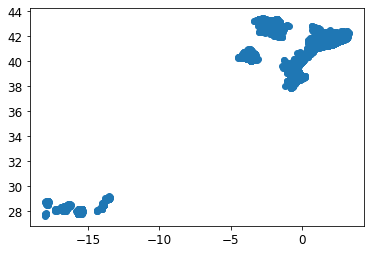

In [346]:
plt.scatter(df_clients['long'], df_clients['lat'])

As expected, the data is clumped according to region. There are no outliers.

#### 2.2.2.4 – Check Abnormalities Among Categorical Variables

In [347]:
for col in df_clients.columns.difference(['client_id']):
    if df_clients.dtypes[col].name == 'category':
        with pd.option_context('display.max_rows', None):
            print(df_clients[col].value_counts(), '\n')

501.0    66
665.0    56
106.0    49
111.0    41
132.0    41
126.0    38
528.0    35
518.0    25
108.0    23
85.0     22
112.0    21
444.0    20
561.0    18
519.0    18
141.0    18
584.0    15
515.0    14
137.0    14
440.0    13
494.0    13
588.0    12
82.0     12
572.0    11
473.0    11
120.0    11
597.0    10
121.0    10
312.0    10
124.0    10
684.0    10
118.0    10
147.0    10
130.0     9
110.0     9
94.0      9
135.0     9
502.0     9
86.0      9
578.0     8
579.0     8
577.0     8
517.0     8
150.0     8
113.0     8
127.0     8
101.0     8
257.0     7
509.0     7
143.0     7
100.0     7
107.0     7
83.0      7
191.0     7
477.0     6
514.0     6
677.0     6
547.0     6
441.0     6
102.0     6
583.0     6
520.0     6
194.0     6
247.0     6
97.0      5
103.0     5
395.0     5
104.0     5
91.0      5
542.0     5
88.0      5
607.0     5
360.0     5
220.0     5
580.0     5
139.0     5
131.0     5
133.0     5
114.0     5
239.0     5
78.0      4
521.0     4
184.0     4
138.0     4
84.0

In [348]:
df_clients.isna().sum()

client_id          0
lat                0
long               0
gov_body           0
assoc_id        8309
sub_assoc_id    8310
type               0
dtype: int64

NAs are for schools that are not part of an association. We will replace these with '0'.

In [349]:
df_clients['assoc_id'] = df_clients['assoc_id'].cat.add_categories(0).fillna(0)
df_clients['sub_assoc_id'] = df_clients['sub_assoc_id'].cat.add_categories(0).fillna(0)

In [350]:
sum(df_clients.isna().sum())

0

#### 2.2.2.5 – Merge with Primary Dataset

In [351]:
df_full = df_full.merge(df_clients, left_on = 'client_id', right_on = 'client_id', how = 'left')

### 2.2.3 – Add Course Information

In [352]:
df_courses

,Curso,N_Curso
0,00020,0 años
1,00021,1 año
2,00022,2 años
3,00023,3 años
4,00024,4 años
5,00025,5 años
6,00026,1º Primaria
7,00027,2º Primaria
8,00028,3º Primaria
9,00029,4º Primaria


In [353]:
df_courses['Curso'] = df_courses['Curso'].str[-2:]

dict_courses = df_courses.set_index('Curso')['N_Curso'].to_dict()

df_full['course'] = df_full['course'].astype(str).map(dict_courses)

df_full['course'].isna().sum()

0

### 2.2.4 – Add Subject Information

In [354]:
df_subject2 = df_subject.iloc[:-2,:]
df_subject2['Asignatura'] = df_subject2['Asignatura'].astype(int)
dict_subjects = df_subject2.set_index('Asignatura')['N_Asignatura'].to_dict()
dict_subjects[275] = 'other'
dict_subjects[900] = 'other2'
df_full['subject'] = df_full['subject'].map(dict_subjects)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 2.2.5 – Add Material Type Information

In [355]:
df_mat['Tipo Material Educat'] = df_mat['Tipo Material Educat'].str[-1:]
dict_mat = df_mat.set_index("Tipo Material Educat")['N_TME'].to_dict()
df_full['material_type'] = df_full['material_type'].astype(str).map(dict_mat)

### 2.2.6 – Add Language Information

In [356]:
dict_lang = df_lang.set_index('Lengua')['N_Lengua'].to_dict()
dict_lang[0] = 'Other'
df_full['language'] = df_full['language'].map(dict_lang)

### 2.2.7 – Add Support Type Information

In [357]:
df_sup = df_sup.iloc[:4,:]
df_sup['Tipo Soporte Actual'] = df_sup['Tipo Soporte Actual'].astype(int)
dict_sup = df_sup.set_index("Tipo Soporte Actual")['N_TS'].to_dict()
df_full['support_type'] = df_full['support_type'].map(dict_sup)

<br/><br/>

## 2.3 – Further Preperation

### 2.3.1 – Rearrange Columns

In [358]:
df_full = df_full[['_id', 'client_id', 'lat', 'long', 'gov_body', 'assoc_id','sub_assoc_id', 'type',
                   'course', 'subject', 'material_type', 'language', 'support_type',
                   'year_1', 'class_size_1', 'value_1', 'editorial_group_1',
                   'year_2', 'class_size_2', 'value_2', 'editorial_group_2',
                   'new', 'target',]]

### 2.3.2 – Redefine Datatypes

In [359]:
cat = ['_id', 'client_id', 'gov_body', 'assoc_id', 'sub_assoc_id','type', 'course', 'subject', 'material_type', 'language', 'support_type', 'year_1','editorial_group_1', 'year_2','editorial_group_2']

df_full[cat] = df_full[cat].astype('str').astype('category')
df_full['new'] = df_full['new'].astype('category')
df_full['target'] = df_full['target'].astype('category')

In [360]:
df_full.dtypes

_id                  category
client_id            category
lat                   float64
long                  float64
gov_body             category
assoc_id             category
sub_assoc_id         category
type                 category
course               category
subject              category
material_type        category
language             category
support_type         category
year_1               category
class_size_1          float64
value_1               float64
editorial_group_1    category
year_2               category
class_size_2          float64
value_2               float64
editorial_group_2    category
new                  category
target               category
dtype: object

### 2.3.3 – Aggregate Categories

In [361]:
for col in df_full.columns.difference(['_id', 'client_id']):
    if df_full.dtypes[col].name == 'category':
            print(col)
            print(len(df_full[col].value_counts()), '\n')

assoc_id
267 

course
18 

editorial_group_1
42 

editorial_group_2
42 

gov_body
7 

language
5 

material_type
4 

new
2 

sub_assoc_id
71 

subject
80 

support_type
2 

target
3 

type
3 

year_1
4 

year_2
3 



In [362]:
df_insight = df_full.copy()

#### 2.3.3.1 – Aggregate Associations

In [363]:
assoc = df_full['assoc_id'].value_counts()
mask = (assoc/assoc.sum() * 100).lt(0.2)
df_full['assoc_id'] = np.where(df_full['assoc_id'].isin(assoc[mask].index),'Other',df_full['assoc_id'])
df_full['assoc_id'] = df_full['assoc_id'].astype('category')

#### 2.3.3.2 – Aggregate Sub-Associations

In [364]:
sub_assoc = df_full['sub_assoc_id'].value_counts()
mask = (sub_assoc/sub_assoc.sum() * 100).lt(0.2)
df_full['sub_assoc_id'] = np.where(df_full['sub_assoc_id'].isin(sub_assoc[mask].index),'Other',df_full['sub_assoc_id'])
df_full['sub_assoc_id'] = df_full['sub_assoc_id'].astype('category')

#### 2.3.3.3 – Aggregate Subjects

In [365]:
subject = df_full['subject'].value_counts()
mask = (subject/subject.sum() * 100).lt(0.5)
df_full['subject'] = np.where(df_full['subject'].isin(subject[mask].index),'Other',df_full['subject'])
df_full['subject'] = df_full['subject'].astype('category')

#### 2.3.3.4 – Aggregate Editorial Group I

In [366]:
eg = df_full['editorial_group_1'].value_counts()
mask = (eg/eg.sum() * 100).lt(0.8)
df_full['editorial_group_1'] = np.where(df_full['editorial_group_1'].isin(eg[mask].index),'Other',df_full['editorial_group_1'])
df_full['editorial_group_1'] = df_full['editorial_group_1'].astype('category')

In [367]:
for col in df_full[['assoc_id', 'sub_assoc_id', 'subject', 'editorial_group_1']]:
    print(col)
    print(len(df_full[col].value_counts()), '\n')

assoc_id
27 

sub_assoc_id
17 

subject
31 

editorial_group_1
17 



<br/><br/>

## 2.4 – Overview and Insights II

### 2.4.1 – Overview of Users and Non-Users

In [368]:
i = 2017

for df in merged_dfs:
    if i != 2019:
        print('\033[1m', i, '\033[0m\n')
        print('Total new courses: \t\t {}'.format(df.new.sum()))
        print('\t Non-users: \t\t {}'.format(len(df[(df['new'] == 1) & (df['target'] == 1)])))
        print('\t Users: \t\t {}'.format(len(df[(df['new'] == 1) & (df['target'] == 0)])))
        print('\n')
    else:
        print('\033[1m 2019 \033[0m\n')
        print('Total new courses: \t\t {}'.format(df.new.sum()))
        print('\n')
    
    if i != 2019:
        print('Newly non-users:\t\t {}'.format(len(df[df['target'] == 1])))
        print('\tFrom editorial group:\t {}'.format(len(df[(df['target'] == 1) & (df['new'] == 0)])))
        print('\tNew course:\t\t {}'.format(len(df[(df['target'] == 1) & (df['new'] == 1)])))
        print('\n'*2)
    i += 1

 2017 

Total new courses: 		 97129
	 Non-users: 		 25110
	 Users: 		 72019


Newly non-users:		 45226
	From editorial group:	 20116
	New course:		 25110



 2018 

Total new courses: 		 123562
	 Non-users: 		 37909
	 Users: 		 85653


Newly non-users:		 55753
	From editorial group:	 17844
	New course:		 37909



 2019 

Total new courses: 		 81022




<br/><br/>

### 2.4.2 – Loss of Clients

In [369]:
i = 2017

for df in merged_dfs[:-1]:
    switched = df[(df.editorial_group_1 == 1) & (df.editorial_group_2 != 1)].editorial_group_2.value_counts()
    
    print('\033[1m In {},'.format(i), 'Client customers left for:', '\033[0m \n')
    print(switched.head(sum(switched != 0)))
    print('\n' *2)
    i += 1

 In 2017, SM customers left for:  

90    3392
3      478
2      345
6      201
34     189
5      148
4      140
8      135
40     100
19      78
18      64
9       64
16      32
20      29
24      17
30      15
43      15
35      12
17      12
10       7
44       7
36       6
13       5
25       4
22       4
26       4
28       4
38       3
7        3
32       2
39       2
15       2
31       2
Name: editorial_group_2, dtype: int64



 In 2018, SM customers left for:  

90    3161
3      761
2      615
6      471
34     150
8      149
5      144
40     109
4       94
19      68
18      64
9       43
35      37
24      28
26      27
10      25
20      25
16      23
17      13
44      12
25      10
28       8
36       7
30       5
37       3
13       3
38       2
43       2
22       1
39       1
15       1
Name: editorial_group_2, dtype: int64





<br/><br/>

<br/><br/>

# 3. Modelling

Supervised binary classification problem.

**1** in target represents that a course will switch to being a non-user. This includes courses that switch from using an editorial group in the base year or new courses that immediately become non-users.

## 3.1 – Defining Functions

In [370]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import itertools

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap, aspect = 'auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation = 45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_model(X,y, model, show_figures = False, variable_importance = False): 
    y_pred = cross_val_predict(model, X, y, cv = 5)
    conf_mat = confusion_matrix(y, y_pred)
    f1score = f1_score(y,y_pred)
    accuracy = accuracy_score(y,y_pred)
    model.fit(X, y) 
    print("F1 Score = {0:.4f}".format(f1score))
    print("Accuracy = {0:.4f}".format(accuracy))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
    if variable_importance:
        get_feature_importance(model, X.columns, n_features=25)
    return model, f1score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()

<br/><br/>

## 3.2 – Prepare Training Set

### 3.2.1 – Normalize and Unfold

In [371]:
categorical_cols = df_full.columns[df_full.dtypes=='category'].tolist()
categorical_cols.remove('target')
categorical_cols.remove('client_id')
categorical_cols.remove('_id')
categorical_cols.remove('editorial_group_2')

numerical_cols = df_full.columns[df_full.dtypes!='category'].tolist()

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

In [372]:
dummified_dataset = pd.concat([df_full['_id'].reset_index(drop = True),
                               pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(df_full[numerical_cols])), columns = numerical_cols).reset_index(drop = True),
                               pd.DataFrame(ohe.fit_transform(df_full[categorical_cols]).toarray(), columns = ohe.get_feature_names(categorical_cols)).reset_index(drop = True),
                               df_full['target'].reset_index(drop = True)], axis = 1)

### 3.2.2 – Sample

#### 3.2.2.1 – Undersample Majority Class

In [373]:
df_full.iloc[:len(train)]['target'].value_counts()

 0    1103793
 1     100979
-1          0
Name: target, dtype: int64

In [374]:
train_0 = dummified_dataset[dummified_dataset['target'] == 0]
train_1 = dummified_dataset[dummified_dataset['target'] == 1]
test_ = dummified_dataset[dummified_dataset['target'] == -1]

train_0_us = train_0.sample(frac = (len(train_1)/len(train_0)), random_state = 1)

modeling_df = train_0_us.append([train_1, test_]).reset_index(drop = True)

modeling_df['target'].value_counts()

-1    617860
 1    100979
 0    100979
Name: target, dtype: int64

In [375]:
len(set(df19['_id'])) == len(set(df19['_id']).intersection(set(modeling_df['_id'])))

True

#### 3.2.2.2 – Training Sample

In [376]:
sample = modeling_df[modeling_df['target'] != -1].sample(frac = 0.2, random_state = 42)

<br/><br/>

## 3.3 – Baseline Models

### 3.3.1 – Baseline Logistic Regression

In [377]:
from sklearn import linear_model

LR_baseline, score = train_model(sample.drop(['_id', 'target'], axis = 1),
                                 sample['target'],
                                 linear_model.LogisticRegression(max_iter = 10000, penalty = 'none'))

F1 Score = 0.8069
Accuracy = 0.8048


In [378]:
results_df = pd.DataFrame(columns=['Approach', 'F1 Score'])
results_df.loc[len(results_df)] = ['LR Baseline', score]
results_df

,Approach,F1 Score
0,LR Baseline,0.806868


### 3.3.2 – Baseline Random Forest

In [379]:
from sklearn.ensemble import RandomForestClassifier

RF_baseline, score = train_model(sample.drop(['_id', 'target'], axis = 1),
                                 sample['target'],
                                 RandomForestClassifier(n_estimators=100, random_state=42))

F1 Score = 0.8178
Accuracy = 0.8186


In [380]:
results_df.loc[len(results_df)] = ['RF Baseline', score]
results_df

,Approach,F1 Score
0,LR Baseline,0.806868
1,RF Baseline,0.817818


<br/><br/>

## 3.4 – Treating Outliers

In [381]:
def remove_outlier(df_in, col_name, coef):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-coef*iqr
    fence_high = q3+coef*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

outlier_free_dataset = modeling_df[modeling_df['target'] != -1].copy(deep=True)

Analyzing outliers of column: lat
21512 outliers removed


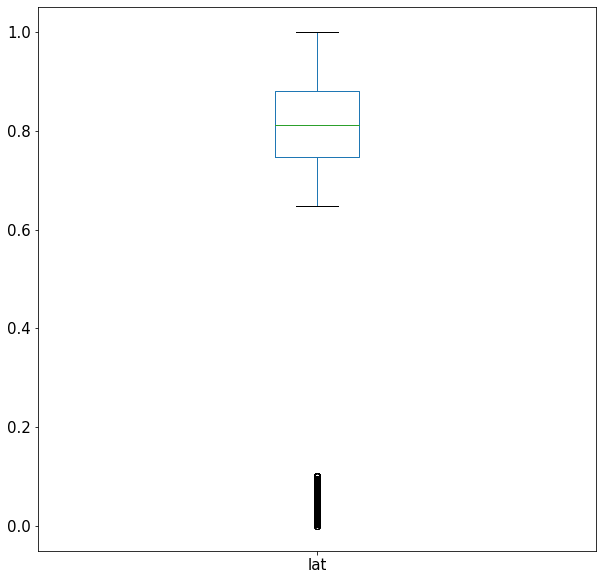

Analyzing outliers of column: long
0 outliers removed


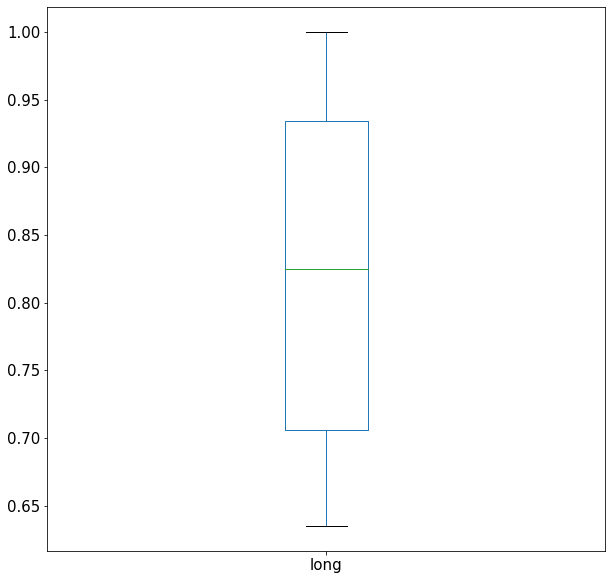

Analyzing outliers of column: class_size_1
0 outliers removed


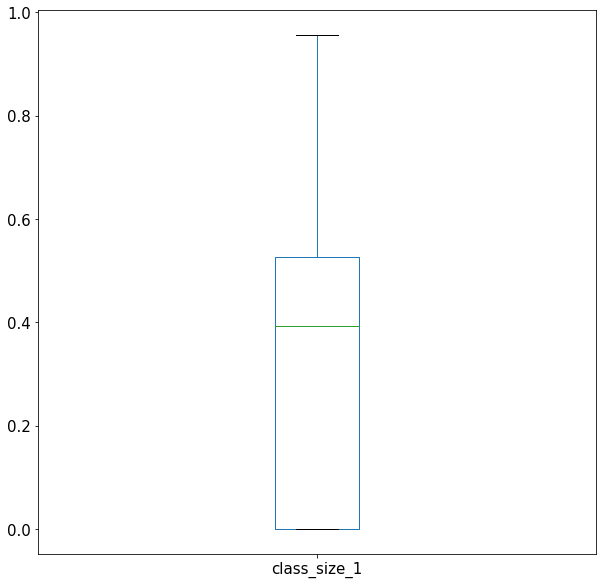

Analyzing outliers of column: value_1
0 outliers removed


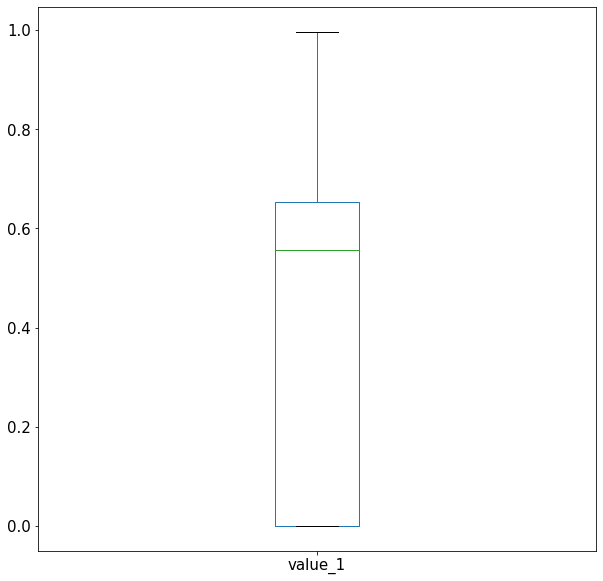

Analyzing outliers of column: class_size_2
0 outliers removed


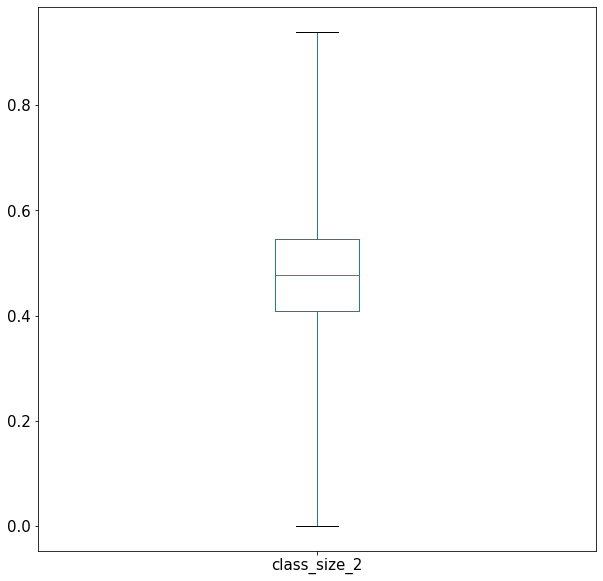

Analyzing outliers of column: value_2
1675 outliers removed


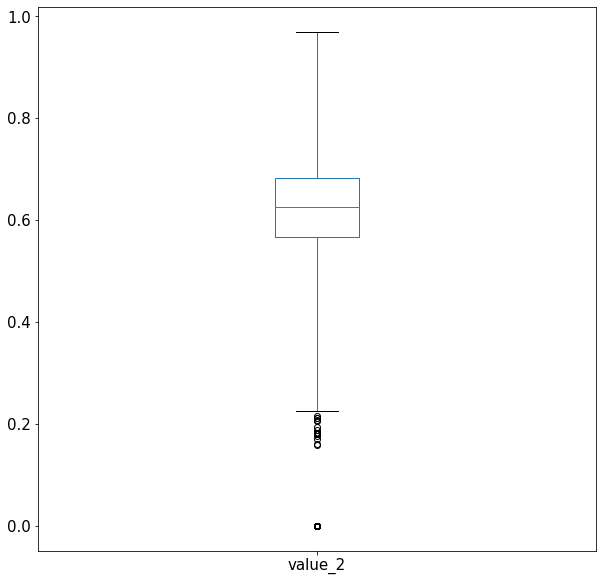

In [382]:
for (columnName, _) in outlier_free_dataset.iteritems():
    if columnName in numerical_cols: # IS numeric
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        outlier_free_dataset.boxplot([columnName], grid=False, fontsize=15, whis=3)
        outlier_free_dataset = remove_outlier(outlier_free_dataset,columnName, 3)
        plt.show()

### 3.4.1 – Outlier-Free Models

In [383]:
sample2 = outlier_free_dataset.sample(frac = 0.2, random_state = 42)

#### 3.4.1.1 – Logistic Regression

In [384]:
outlier_free_model, score = train_model(sample2.drop(['_id', 'target'], axis=1),
                                        sample2['target'], 
                                        linear_model.LogisticRegression(max_iter=10000, penalty='none'))

F1 Score = 0.8076
Accuracy = 0.8080


In [385]:
results_df.loc[len(results_df)] = ['LR without outliers', score]
results_df

,Approach,F1 Score
0,LR Baseline,0.806868
1,RF Baseline,0.817818
2,LR without outliers,0.807611


#### 3.4.1.2 – Random Forest

In [386]:
RF_baseline, score = train_model(sample2.drop(['_id', 'target'], axis = 1),
                                 sample2['target'],
                                 RandomForestClassifier(n_estimators=100, random_state=42))

F1 Score = 0.8167
Accuracy = 0.8198


In [387]:
results_df.loc[len(results_df)] = ['RF without outliers', score]
results_df

,Approach,F1 Score
0,LR Baseline,0.806868
1,RF Baseline,0.817818
2,LR without outliers,0.807611
3,RF without outliers,0.816734


We see that performance is better with outliers kept in the model.

<br/><br/>

## 3.5 – Dimentionality Reduction

### 3.5.1 – Numeric Variables

#### 3.5.1.1 – Correlation Among Features

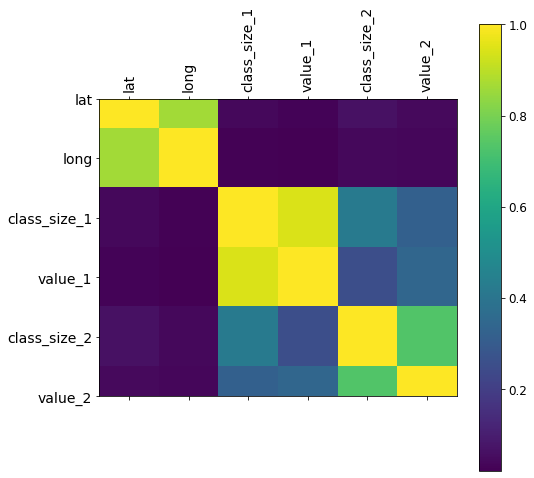

In [388]:
plt.figure(figsize=(8, 8))
plt.matshow(modeling_df[numerical_cols].corr(), fignum = 1)
plt.xticks(range(modeling_df[numerical_cols].shape[1]), numerical_cols, fontsize = 14, rotation = 90)
plt.yticks(range(modeling_df[numerical_cols].shape[1]), numerical_cols, fontsize = 14)
plt.colorbar()
plt.show()

#### 3.5.1.2 – Principal Component Analysis

In [389]:
from sklearn.decomposition import PCA

pca = PCA()

principalComponents = pca.fit_transform(modeling_df[numerical_cols])

pd.DataFrame(principalComponents).describe()

,0,1,2,3,4,5
count,8.198180e+05,8.198180e+05,8.198180e+05,8.198180e+05,8.198180e+05,8.198180e+05
mean,-1.324973e-15,-1.098396e-15,-6.063871e-16,-2.087561e-16,-3.102421e-16,6.752336e-18
std,3.445139e-01,3.292619e-01,1.478201e-01,8.985484e-02,7.761147e-02,2.483085e-02
min,-7.772617e-01,-5.671267e-01,-6.906036e-01,-1.384448e-01,-1.939034e-01,-4.579336e-01
25%,-2.563083e-01,-1.749504e-01,-8.794557e-02,-7.061341e-02,-3.439031e-02,-5.967067e-03
50%,-1.217237e-01,-4.949799e-02,-1.429446e-02,-4.701451e-02,-8.823973e-03,-5.331709e-04
75%,2.461997e-01,7.917728e-02,7.455205e-02,8.445330e-02,1.792129e-02,5.229125e-03
max,1.121657e+00,1.184181e+00,8.466876e-01,3.003429e-01,9.825346e-01,4.736715e-01


In [390]:
pca.explained_variance_ratio_

array([0.45014886, 0.41117381, 0.08287229, 0.03062143, 0.02284517,
       0.00233844])

In [391]:
print('The first three principal components explain {}% of the variance.'.format(round(sum(pca.explained_variance_ratio_[:3])*100, 2)))

The first three principal components explain 94.42% of the variance.


#### 3.5.1.3 – Pricipal Component Selection

In [392]:
pd.DataFrame(principalComponents[:,:3])

,0,1,2
0,-0.210642,-0.171976,0.056749
1,-0.178172,-0.163717,0.077528
2,-0.029370,-0.187915,0.258196
3,-0.410268,-0.095546,-0.091355
4,0.452909,0.853563,0.137209
...,...,...,...
819813,0.481419,-0.382422,-0.213729
819814,0.527206,-0.396569,0.014750
819815,0.495980,-0.386912,-0.141016
819816,0.527206,-0.396569,0.014750


In [393]:
t1 = modeling_df.drop(numerical_cols, axis = 1)
t2 = pd.DataFrame(principalComponents[:,:3])
t2.columns = ['PC1', 'PC2', 'PC3']

In [394]:
pc_df = pd.concat([t2, t1], axis=1)

In [395]:
pc_df

,PC1,PC2,PC3,_id,gov_body_Cataluña,gov_body_Comunidad Valenciana,gov_body_Islas Canarias,gov_body_La Rioja,gov_body_Madrid,gov_body_Navarra,...,editorial_group_1_8,editorial_group_1_9,editorial_group_1_90,editorial_group_1_Other,year_2_2017,year_2_2018,year_2_2019,new_0,new_1,target
0,-0.210642,-0.171976,0.056749,11760028601011,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,-0.178172,-0.163717,0.077528,11731124631011,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,-0.029370,-0.187915,0.258196,19562323631011,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,-0.410268,-0.095546,-0.091355,16675536361011,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,0.452909,0.853563,0.137209,12462429131311,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819813,0.481419,-0.382422,-0.213729,212534332621312,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1
819814,0.527206,-0.396569,0.014750,212534342801311,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1
819815,0.495980,-0.386912,-0.141016,212534232592611,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1
819816,0.527206,-0.396569,0.014750,212534342791311,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1


#### 3.5.1.4 – Logistic Regression with PCs

In [396]:
sample3 = pc_df[pc_df['target'] != -1].sample(frac = 0.2, random_state = 42)

In [397]:
lr_pca, score = train_model(sample3.drop(['_id', 'target'], axis = 1),
                            sample3['target'],
                            linear_model.LogisticRegression(max_iter = 10000, penalty = 'none'))

F1 Score = 0.8061
Accuracy = 0.8039


In [398]:
results_df.loc[len(results_df)] = ['LR w/ PCs', score]
results_df

,Approach,F1 Score
0,LR Baseline,0.806868
1,RF Baseline,0.817818
2,LR without outliers,0.807611
3,RF without outliers,0.816734
4,LR w/ PCs,0.806091


#### 3.5.1.5 – Random Forest with PCs

In [399]:
rf_pca, score = train_model(sample3.drop(['_id', 'target'], axis = 1),
                            sample3['target'],
                            RandomForestClassifier(n_estimators=100, random_state=42))

F1 Score = 0.8096
Accuracy = 0.8100


In [400]:
results_df.loc[len(results_df)] = ['RF w/ PCs', score]
results_df

,Approach,F1 Score
0,LR Baseline,0.806868
1,RF Baseline,0.817818
2,LR without outliers,0.807611
3,RF without outliers,0.816734
4,LR w/ PCs,0.806091
5,RF w/ PCs,0.809605


### 3.5.2 – Categorical Variables

In [401]:
cat_train = modeling_df[modeling_df['target'] != -1][list(modeling_df.columns.difference(numerical_cols))]

#### 3.5.2.1 – Chi-Squared

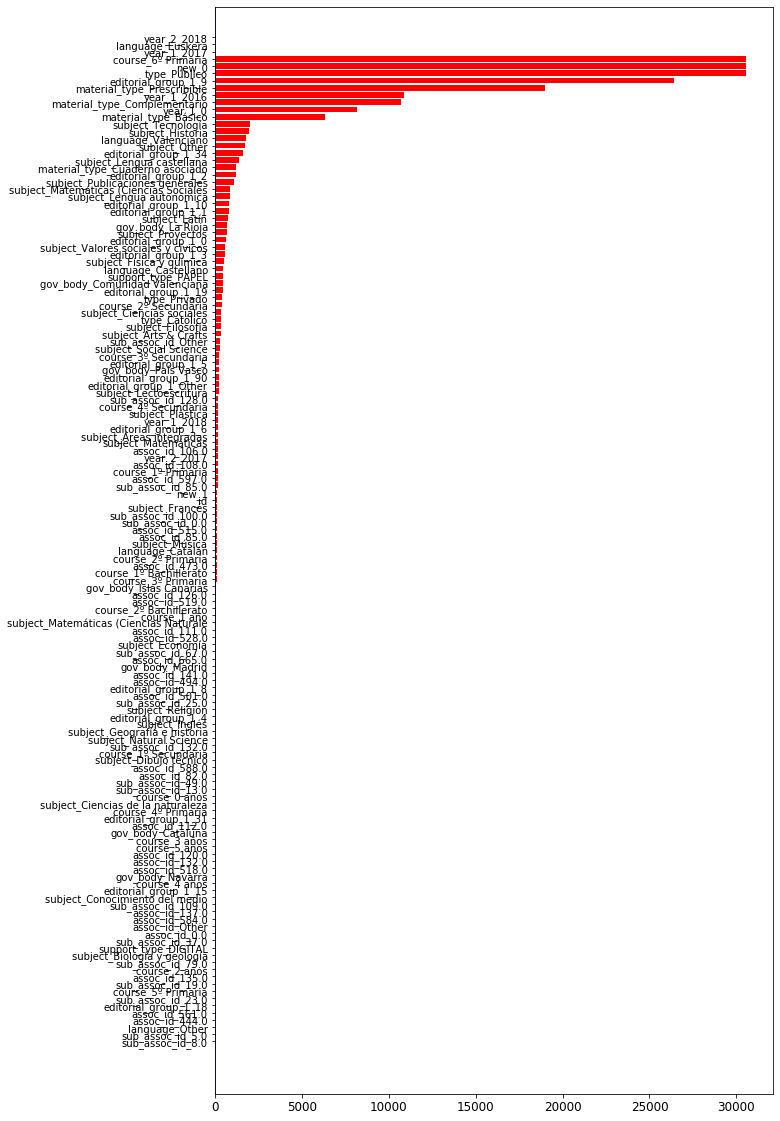

ChiSquared Threshold 0


In [402]:
from sklearn.feature_selection import SelectKBest, chi2
from operator import itemgetter
from collections import defaultdict

chi2_selector = SelectKBest(score_func = chi2).fit(cat_train.drop(['_id', 'target'],axis=1),
                                                 cat_train['target'])

# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = defaultdict(float)
for i in range(len(cat_train.drop(['_id', 'target'],axis=1).columns)):
    chi2_features[cat_train.drop(['target'],axis=1).columns[indices[i]]] += chi2_selector.scores_[indices[i]]
    
items = sorted(chi2_features.items(), key = itemgetter(1), reverse = True)
keys, values = list(zip(*items))

plt.figure(figsize=(10,20))
plt.yticks(list(range(len(keys))), keys, rotation=0, fontsize=10)
plt.barh(list(range(len(keys))), values, color='r', align='center')
# chi2_th = pd.Series(list(chi2_features.values())).quantile(0.25) * 10
chi2_th = 0
plt.axvline(chi2_th, color='blue')
plt.gca().invert_yaxis()

plt.show()

print("ChiSquared Threshold", chi2_th)

#### 3.4.2.1 – Logistic Regression with Reduced Features

In [403]:
chi2_features_to_remove = dict(filter(lambda x: x[1] <= chi2_th, chi2_features.items())).keys()

chi2_model, score = train_model(sample.drop(list(chi2_features_to_remove)+['_id', 'target'], axis=1),
                                sample['target'],
                                linear_model.LogisticRegression(max_iter=10000, penalty='none'),
                                False)

F1 Score = 0.8069
Accuracy = 0.8048


In [404]:
results_df.loc[len(results_df)] = ['LR Chi2 Selection', score]
results_df

,Approach,F1 Score
0,LR Baseline,0.806868
1,RF Baseline,0.817818
2,LR without outliers,0.807611
3,RF without outliers,0.816734
4,LR w/ PCs,0.806091
5,RF w/ PCs,0.809605
6,LR Chi2 Selection,0.806868


### 3.4.3 – Embedded Techniques

#### 3.4.3.1 – Ridge

In [405]:
ridge_model, score = train_model(sample.drop(['_id', 'target'], axis=1),
                                 sample['target'],
                                 linear_model.RidgeClassifierCV(alphas=10**np.linspace(1,-4,100)))

F1 Score = 0.8041
Accuracy = 0.8023


In [406]:
results_df.loc[len(results_df)] = ['LR Ridge', score]
results_df

,Approach,F1 Score
0,LR Baseline,0.806868
1,RF Baseline,0.817818
2,LR without outliers,0.807611
3,RF without outliers,0.816734
4,LR w/ PCs,0.806091
5,RF w/ PCs,0.809605
6,LR Chi2 Selection,0.806868
7,LR Ridge,0.804111


<br/><br/>

<br/><br/>

# Final Model 

In [407]:
final_model = RF_baseline

final_pred = final_model.predict(modeling_df[modeling_df['target'] == -1].drop(['_id', 'target'], axis=1))
predictions = pd.DataFrame({'ID':modeling_df[modeling_df['target'] == -1]['_id'], 'Prediction':final_pred})
df19 = df19.sort_values('_id').reset_index(drop = True)
predictions = predictions.sort_values('ID').reset_index(drop = True)
df19['editorial_group'] = predictions['Prediction']
df19.rename(columns={'editorial_group':'Prediction'}, inplace=True)
df19 = df19.drop(['_id'], axis = 1)

df19.to_csv("CDS_2019.csv", index = False)

<br/><br/>

<br/><br/>

# Insights

In [410]:
df_in18_19 = df_insight[df_insight['target'] == -1].sort_values('_id')
df_in18_19 = df_in18_19.reset_index(drop=True)
df_in_19 = df19.copy()
df_in_19['Prediction'] = df_in_19['Prediction'].astype('category')
df_in18_19['target'] = df_in_19['Prediction']

In [412]:
from scipy.special import inv_boxcox

df_in18_19['value_1'] = inv_boxcox((df_in18_19['value_1']), 0) - 1
df_in18_19['value_2'] = inv_boxcox((df_in18_19['value_2']), 0) - 1
df_in_19['value'] = inv_boxcox((df_in_19['value']), 0) - 1

In [483]:
df_sm = df_in18_19[(df_in18_19['editorial_group_1'] == '1')]
df_sm_gb = df_sm[df_sm['target'] == 1].groupby(['client_id'],
                                               as_index=False)['value_2'].sum().sort_values('value_2',ascending = False).reset_index(drop = True)
df_cl_loc = df_clients.iloc[:,:4]
df_sm_gb['client_id'] = df_sm_gb['client_id'].astype('int')
df_sm_cl = pd.merge(df_sm_gb, df_cl_loc, how = 'left', left_on = ['client_id'], right_on = ['client_id'])

#### Predicted Lost Revenue

In [486]:
df_sm_cl[df_sm_cl['value_2']>0]['value_2'].sum()

6004775.91

#### Where to Focus

In [487]:
df_sm_cl[df_sm_cl['value_2']>0]['value_2'].head(1000).sum()

5012838.58

In [488]:
df_sm_cl[df_sm_cl['value_2']>0]['value_2'].head(500).sum()

3715089.0300000003

In [501]:
priority = df_sm_cl[df_sm_cl['value_2']>0]
priority

,client_id,value_2,lat,long,gov_body
0,175016,51700.19,43.336429,-2.977158,País Vasco
1,199860,45925.23,43.261994,-2.941421,País Vasco
2,117420,38334.35,41.587204,2.544656,Cataluña
3,132894,36051.86,39.486273,-0.396107,Comunidad Valenciana
4,205460,32251.86,40.447099,-3.688633,Madrid
...,...,...,...,...,...
2129,171421,38.20,28.800311,-17.759712,Islas Canarias
2130,136547,30.11,40.376946,-3.777856,Madrid
2131,165782,27.42,39.938570,-0.094154,Comunidad Valenciana
2132,127281,19.34,42.703776,-1.508325,Navarra


In [502]:
cities = priority.groupby(['gov_body'], as_index=False)['value_2'].sum().sort_values('value_2',ascending = False).reset_index(drop = True)
cities

,gov_body,value_2
0,Cataluña,2177049.09
1,Comunidad Valenciana,1421205.24
2,Madrid,1409700.65
3,País Vasco,505523.39
4,Islas Canarias,356846.54
5,La Rioja,74707.80
6,Navarra,59743.20


In [508]:
cities[:3]['value_2'].sum()

5007954.979999997